# Plot surface elevations and bed topography along the centerline

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import xarray as xr
import rioxarray as rxr
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from tqdm.auto import tqdm

## Define paths in directory

In [2]:
# Path to Hubbard data for convenience
data_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'

# Where figure will be saved
figures_out_path = data_path# os.path.join(data_path, 'make_paper_figures') 

# Bed topography
bed_fn = os.path.join(data_path, 'data', 'hubbard_bedrock_icebridge.tif')

# Centerline
cl_fn = os.path.join(data_path, 'data', 'center_50m.gpkg')

# Surface elevations
h_cl_fn = os.path.join(data_path, 'data', 'centerline_surface_elevation_timeseries_smooth.csv')

## Load data

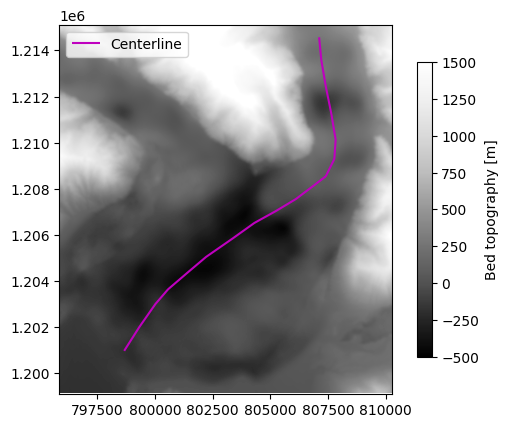

In [3]:
# Centerline
cl = gpd.read_file(cl_fn)
# calculate distance vector
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist
cl_dist = create_distance_vector(cl.geometry[0])
# Flip to start near terminus
cl_dist = np.flip(cl_dist)

# Bed
bed = xr.open_dataset(bed_fn)
x_samp, y_samp = cl.geometry[0].coords.xy
bed_cl = [bed.sel(x=x, y=y, method='nearest').band_data.data[0] for x, y in list(zip(x_samp, y_samp))]

# Surface elevations along centerline
h_cl_df = pd.read_csv(h_cl_fn)
h_cl_df['Date'] = pd.to_datetime(h_cl_df['Date'])

# Plot bed and centerline map
fig, ax = plt.subplots()
bed_im = ax.imshow(bed.band_data.data[0], cmap='Greys_r', clim=(-0.5e3, 1.5e3),
                   extent=(np.min(bed.x.data), np.max(bed.x.data),
                           np.min(bed.y.data), np.max(bed.y.data)))
cl.plot(ax=ax, color='m', label='Centerline')
ax.legend(loc='upper left')
fig.colorbar(bed_im, shrink=0.8, label='Bed topography [m]')

plt.show()

## Calculate speed peak strengths along centerline

Copied from Amy's `double_peak_strength` notebook

In [4]:
# -----Calculate summer and winter speed speaks
# Load velocity
ds_fn = os.path.join(data_path, 'data', 'Hubbard_S1.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject('EPSG:3338')
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)

  0%|          | 0/6 [00:00<?, ?it/s]

            2016         2017         2018         2019         2020  \
0            NaN          NaN          NaN          NaN          NaN   
1            NaN          NaN          NaN          NaN          NaN   
2            NaN          NaN          NaN          NaN          NaN   
3            NaN          NaN          NaN          NaN          NaN   
4            NaN          NaN          NaN          NaN          NaN   
..           ...          ...          ...          ...          ...   
354  2185.831708  1889.393089  2368.729938  2326.870903  2031.429195   
355  2180.509158  1881.727683  2359.262842  2327.159260  2027.699302   
356  2177.710579  1884.177461  2368.427291  2348.186999  2040.004013   
357  2181.184729  1891.407619  2383.377012  2375.806431  2057.268660   
358  2205.461103  1913.591908  2367.153070  2427.797182  2098.680277   

            2021  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
35

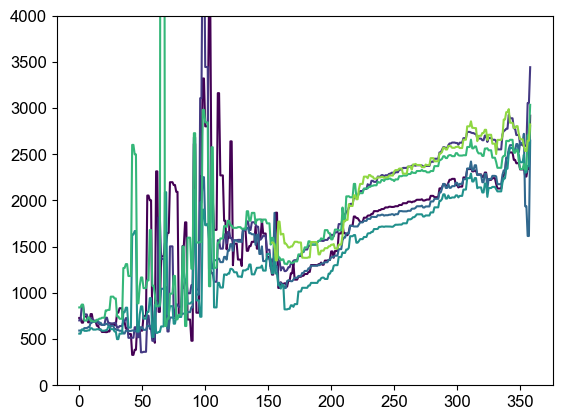

In [164]:
# Calculate strength of speed peaks
strengths_cl = pd.DataFrame()
avgs_cl = pd.DataFrame()
years = [2016, 2017, 2018, 2019, 2020, 2021]
fig, ax = plt.subplots()
i = 0
for year in tqdm(years):

    # Winter peak
    winter_mask = np.logical_or(
        np.logical_and(ds.month >= 10, ds.year == year),
        np.logical_and(ds.month <= 2, ds.year == year+1)
    )
    winter_velocities = ds.v[winter_mask, :, :]
    winter_peak = winter_velocities.max(dim='time')

    # Middle peak
    middle_mask = np.logical_and(
        np.logical_and(ds.month >= 2.05, ds.month <= 4),
        ds.year == year+1,
    )
    middle_velocities = ds.v[middle_mask, :, :]
    middle_min = middle_velocities.min(dim='time')

    # Summer peak
    summer_mask = np.logical_and(
        np.logical_and(ds.month >= 4, ds.month <= 6),
        ds.year == year+1,
    )
    summer_velocities = ds.v[summer_mask, :, :]
    summer_peak = summer_velocities.max(dim='time')


   # Absolute minimum 
    min_mask = np.logical_and(
        np.logical_and(ds.month >= 0, ds.month <= 13),
        ds.year == year+1,
    )
    min_velocities = ds.v[min_mask, :, :]
    abs_min = min_velocities.min(dim='time')

       # Absolute minimum 
    max_mask = np.logical_and(np.logical_and(ds.month >= 0, ds.month <= 13),
                              ds.year == year+1)
    max_velocities = ds.v[max_mask, :, :]
    abs_max = max_velocities.max(dim='time')

    # abs_min = ds.v.min(dim='time')
    # abs_max = ds.v.max(dim='time')
    
    # Strength of double peaks 
    #mask = (winter_peak < middle_min) | (summer_peak < 500)
    ##strength = (winter_peak - middle_min) #/(winter_peak) # (winter_peak/summer_peak)
    #strength = (winter_peak - abs_min) #/(summer_peak-min) # (winter_peak/summer_peak)
    #strength = xr.where(mask, np.nan, strength)

    #AK space grant 
    strength = (abs_max - abs_min)


    # Sample along centerline
    strength_cl_np = [float(strength.sel(x=x, y=y, method='nearest').data) for (x, y) in list(zip(x_samp, y_samp))]
    strength_cl = pd.DataFrame({year: strength_cl_np})
    if year == 2021:
        #strength_cl = strength_cl[153:]
        strength_cl.iloc[:153] = np.nan
        
    # # Smooth over a 500 m window
    strength_cl_smooth = strength_cl.rolling(10).mean()
    
    strengths_cl = pd.concat([strengths_cl, strength_cl_smooth], axis=1)

    avg_mask = np.logical_and(np.logical_and(ds.month >= 0, ds.month <= 13),
                              ds.year == year+1)
    avg_velocities = ds.v[avg_mask, :, :]
    avg = avg_velocities.mean(dim='time')

    avg_cl_np = [float(avg.sel(x=x, y=y, method='nearest').data) for (x, y) in list(zip(x_samp, y_samp))]
    avg_cl = pd.DataFrame({year: avg_cl_np})
    if year == 2021:
        avg_cl.iloc[:153] = np.nan
        
    avg_cl_smooth = avg_cl.rolling(12).mean()
    avgs_cl = pd.concat([avgs_cl, avg_cl_smooth], axis=1)
    # if year == 2021:
    #     #avg_cl = avg_cl[153:]
    #     avg_cl_smooth.iloc[:153] = np.nan
    #     pd.concat([avg_cl, avg_cl_smooth], axis=1)
    # else:
    #     avgs_cl = pd.concat([avg_cl, avg_cl_smooth], axis=1)

    ax.plot(strength_cl[year], '-', color=plt.cm.viridis(i/len(years)))
    i+=1
    # ax.plot(avgs_cl[year], '-')
    # i+=1
    plt.ylim([0, 4000])
print(avgs_cl)    
print(strengths_cl)
plt.show() 

## Plot surface elevation + bed + mean speed peak

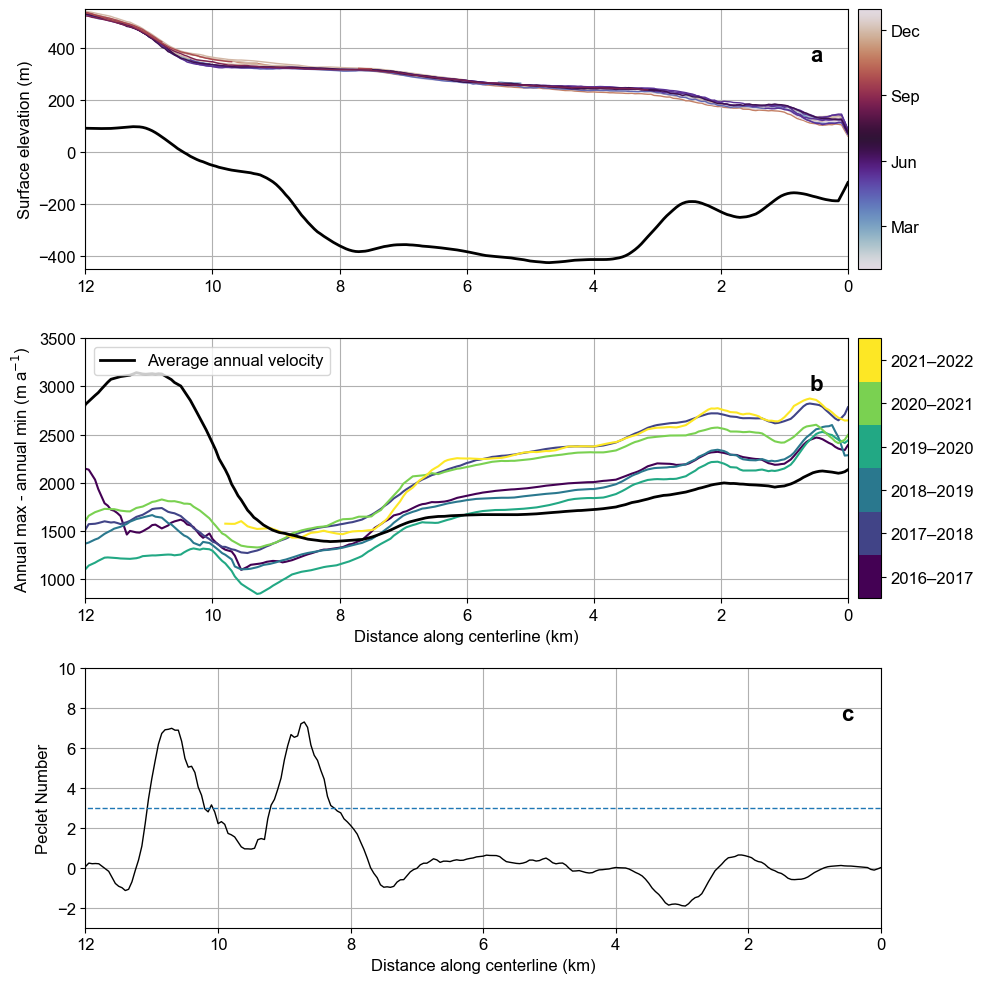

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/elevations_winterpeak_peclet.png


In [165]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(3, 1, figsize=(10,10))
lw=1
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=8):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
    surf = np.mean(h_cl_df.iloc[i][h_cols])
        
# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].grid()
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 550)

### b) Speed strengths
cmap = plt.cm.viridis
colors=[]
for i, year in enumerate(years[0:]):
    colors.append(cmap(i/(len(years)-1)))
    ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl[year], '-', color=colors[i])
ax[1].plot(np.divide(cl_dist, 1e3), avgs_cl.mean(axis=1), '-k', linewidth=lw+1, label='Average annual velocity')
#ax[1].plot(np.divide(cl_dist, 1e3), avgs_mean, '-k', linewidth=lw+1, label='Average annual velocity')
ax[1].legend(loc='upper left')
ax[1].set_xlim(xlim)
ax[1].set_ylim([800, 3500])
ax[1].set_xlabel('Distance along centerline (km)')
ax[1].set_ylabel('Annual max - annual min (m a$^{-1}$)')
#ax[1].set_ylabel('Winter peak - annual min (m a$^{-1}$)')
# Plot colorbar
listed_cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1)  
norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
divider3 = make_axes_locatable(ax[1])
cax3 = divider3.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
cbar.ax.set_yticklabels([f'{year}–{year+1}' for year in years[0:]])  # Customize labels
cbar.ax.tick_params(which='minor', length=0)  

### c) Peclet number
dbdx = np.gradient(bed_cl_smooth, cl_dist)
H_smooth = surf - bed_cl_smooth
Pe = 2 * dbdx/H_smooth * cl_dist
ax[2].plot(np.divide(cl_dist, 1e3), Pe , '-k', linewidth=lw, label='Pe')
ax[2].plot(np.divide(cl_dist, 1e3), np.ones(len(cl_dist))*3 , '--', linewidth=lw, label='Pe')
ax[2].set_xlim(xlim)
ax[2].set_ylim([-3,10])
ax[2].set_xlabel('Distance along centerline (km)')
ax[2].set_ylabel('Peclet Number')

### Add panel labels, adjust axes
labels = ['a', 'b', 'c']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+4)
    axis.grid(True)
    # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'elevations_winterpeak_peclet.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

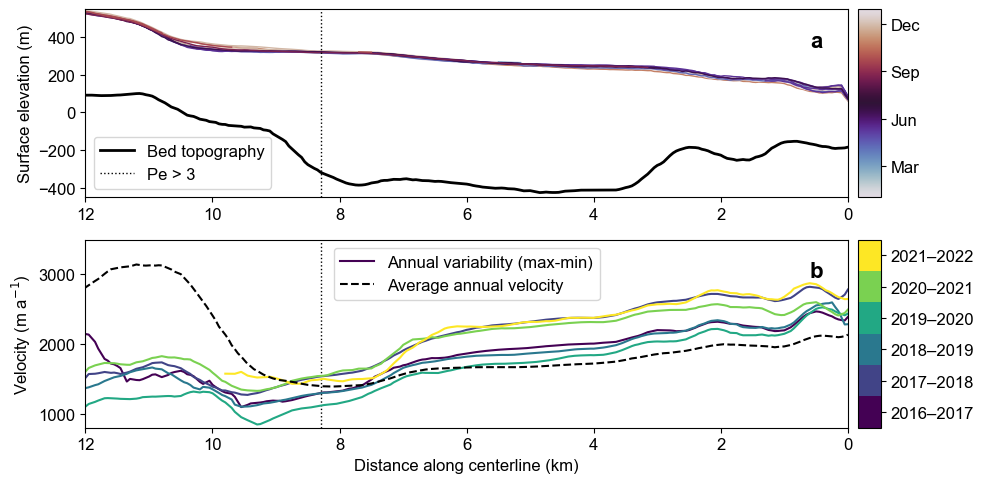

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/elevations_variability_peclet.png


In [166]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(2, 1, figsize=(10,5))
lw=1
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=2):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
    surf = np.mean(h_cl_df.iloc[i][h_cols])
        
# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
#Pe number
dbdx = np.gradient(bed_cl_smooth, cl_dist)
H_smooth = surf - bed_cl_smooth
Pe = 2 * dbdx/H_smooth * cl_dist
indices = np.where(Pe > 3)[0]
last_index = indices[-1]
x_position = cl_dist[last_index] / 1e3
# Plot the vertical line at the last x_position where Pe > 3
ax[0].axvline(x=x_position, color='k', linestyle=':', linewidth=1, label='Pe > 3')
ax[1].axvline(x=x_position, color='k', linestyle=':', linewidth=1)
#print(f"Last position where Pe > 3: {x_position:.2f} km")

ax[0].legend()
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 550)

### b) Speed strengths
cmap = plt.cm.viridis
colors=[]
for i, year in enumerate(years[0:]):
    colors.append(cmap(i/(len(years)-1)))
    ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl[year], '-', color=colors[i], label='Annual variability (max-min)')
ax[1].plot(np.divide(cl_dist, 1e3), avgs_cl.mean(axis=1), '--k', linewidth=lw+0.5, label='Average annual velocity')
handles, labels = ax[1].get_legend_handles_labels()
#ax[1].legend(handles[:2], labels[:2], loc='upper center')
ax[1].legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='upper center')
ax[1].set_xlim(xlim)
ax[1].set_ylim([800, 3500])
ax[1].set_xlabel('Distance along centerline (km)')
ax[1].set_ylabel('Velocity (m a$^{-1}$)')
#ax[1].set_ylabel('Winter peak - annual min (m a$^{-1}$)')
# Plot colorbar
listed_cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1)  
norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
divider3 = make_axes_locatable(ax[1])
cax3 = divider3.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
cbar.ax.set_yticklabels([f'{year}–{year+1}' for year in years[0:]])  # Customize labels
cbar.ax.tick_params(which='minor', length=0)  

### Add panel labels, adjust axes
labels = ['a', 'b']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+4)
    axis.grid(True)
    # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

plt.sca(ax[0])  # Set the current active axis to ax[0]
plt.grid(False)
plt.sca(ax[1])  # Set the current active axis to ax[0]
plt.grid(False)
fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'elevations_variability_peclet.png')
fig.savefig(fig_fn, dpi=600, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

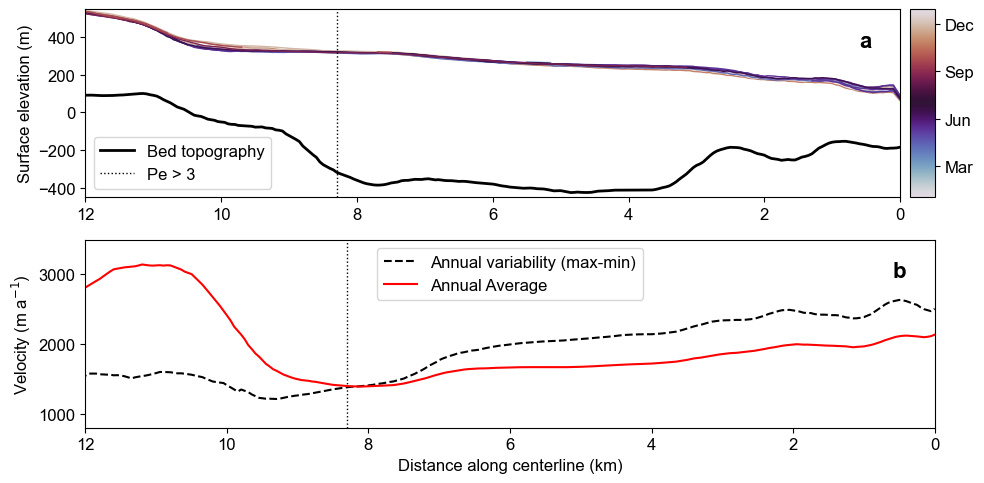

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/elevations_variability_peclet.png


In [167]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(2, 1, figsize=(10,5))
lw=1
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=2):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
    surf = np.mean(h_cl_df.iloc[i][h_cols])
        
# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
#Pe number
dbdx = np.gradient(bed_cl_smooth, cl_dist)
H_smooth = surf - bed_cl_smooth
Pe = 2 * dbdx/H_smooth * cl_dist
indices = np.where(Pe > 3)[0]
last_index = indices[-1]
x_position = cl_dist[last_index] / 1e3
# Plot the vertical line at the last x_position where Pe > 3
ax[0].axvline(x=x_position, color='k', linestyle=':', linewidth=1, label='Pe > 3')
ax[1].axvline(x=x_position, color='k', linestyle=':', linewidth=1)
#print(f"Last position where Pe > 3: {x_position:.2f} km")

ax[0].legend()
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 550)

### b) Speed strengths
cmap = plt.cm.viridis
colors=[]
# for i, year in enumerate(years[0:]):
#     colors.append(cmap(i/(len(years)-1)))
#     ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl[year], '-', color=colors[i])
ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl.mean(axis=1), '--k', linewidth=lw+0.5, label='Annual variability (max-min)')
ax[1].plot(np.divide(cl_dist, 1e3), avgs_cl.mean(axis=1), '-r', linewidth=lw+0.5, label='Annual Average')
#ax[1].plot(np.divide(cl_dist, 1e3), avgs_mean, '-k', linewidth=lw+1, label='Average annual velocity')
ax[1].legend(loc='upper center')
ax[1].set_xlim(xlim)
ax[1].set_ylim([800, 3500])
ax[1].set_xlabel('Distance along centerline (km)')
ax[1].set_ylabel('Velocity (m a$^{-1}$)')
#ax[1].set_ylabel('Winter peak - annual min (m a$^{-1}$)')
# Plot colorbar
# listed_cmap = matplotlib.colors.ListedColormap(colors)
# bounds = np.arange(len(colors) + 1)  
# norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
# sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
# divider3 = make_axes_locatable(ax[1])
# cax3 = divider3.append_axes("right", size="3%", pad=0.1)
# cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
# cbar.ax.set_yticklabels([f'{year}–{year+1}' for year in years[0:]])  # Customize labels
# cbar.ax.tick_params(which='minor', length=0)  

### Add panel labels, adjust axes
labels = ['a', 'b']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+4)
    axis.grid(True)
    # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

plt.sca(ax[0])  # Set the current active axis to ax[0]
plt.grid(False)
plt.sca(ax[1])  # Set the current active axis to ax[0]
plt.grid(False)
fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'elevations_variability_peclet.png')
fig.savefig(fig_fn, dpi=600, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

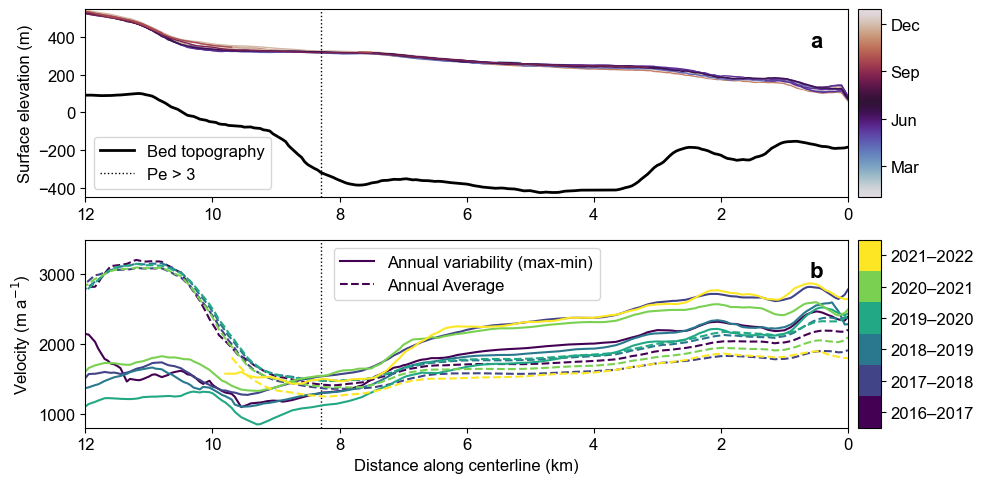

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/elevations_variability_peclet.png


In [168]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(2, 1, figsize=(10,5))
lw=1
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=2):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
    surf = np.mean(h_cl_df.iloc[i][h_cols])
        
# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
#Pe number
dbdx = np.gradient(bed_cl_smooth, cl_dist)
H_smooth = surf - bed_cl_smooth
Pe = 2 * dbdx/H_smooth * cl_dist
indices = np.where(Pe > 3)[0]
last_index = indices[-1]
x_position = cl_dist[last_index] / 1e3
# Plot the vertical line at the last x_position where Pe > 3
ax[0].axvline(x=x_position, color='k', linestyle=':', linewidth=1, label='Pe > 3')
ax[1].axvline(x=x_position, color='k', linestyle=':', linewidth=1)
#print(f"Last position where Pe > 3: {x_position:.2f} km")

ax[0].legend()
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 550)

### b) Speed strengths
cmap = plt.cm.viridis
colors=[]
for i, year in enumerate(years[0:]):
    colors.append(cmap(i/(len(years)-1)))
    line1, = ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl[year], '-', color=colors[i], label='Annual variability (max-min)')
    line2, = ax[1].plot(np.divide(cl_dist, 1e3), avgs_cl[year], '--', color=colors[i], label='Annual Average')
#ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl.mean(axis=1), '--k', linewidth=lw+0.5, label='Annual variability (max-min)')
#ax[1].plot(np.divide(cl_dist, 1e3), avgs_cl.mean(axis=1), '-r', linewidth=lw+0.5, label='Annual Average')
#ax[1].plot(np.divide(cl_dist, 1e3), avgs_mean, '-k', linewidth=lw+1, label='Average annual velocity')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[:2], labels[:2], loc='upper center')
#ax[1].legend(loc='upper center')
ax[1].set_xlim(xlim)
ax[1].set_ylim([800, 3500])
ax[1].set_xlabel('Distance along centerline (km)')
ax[1].set_ylabel('Velocity (m a$^{-1}$)')

# Plot colorbar
listed_cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1)  
norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
divider3 = make_axes_locatable(ax[1])
cax3 = divider3.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
cbar.ax.set_yticklabels([f'{year}–{year+1}' for year in years[0:]])  # Customize labels
cbar.ax.tick_params(which='minor', length=0)  

### Add panel labels, adjust axes
labels = ['a', 'b']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+4)
    axis.grid(True)
    # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

plt.sca(ax[0])  # Set the current active axis to ax[0]
plt.grid(False)
plt.sca(ax[1])  # Set the current active axis to ax[0]
plt.grid(False)
fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'elevations_variability_peclet.png')
fig.savefig(fig_fn, dpi=600, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

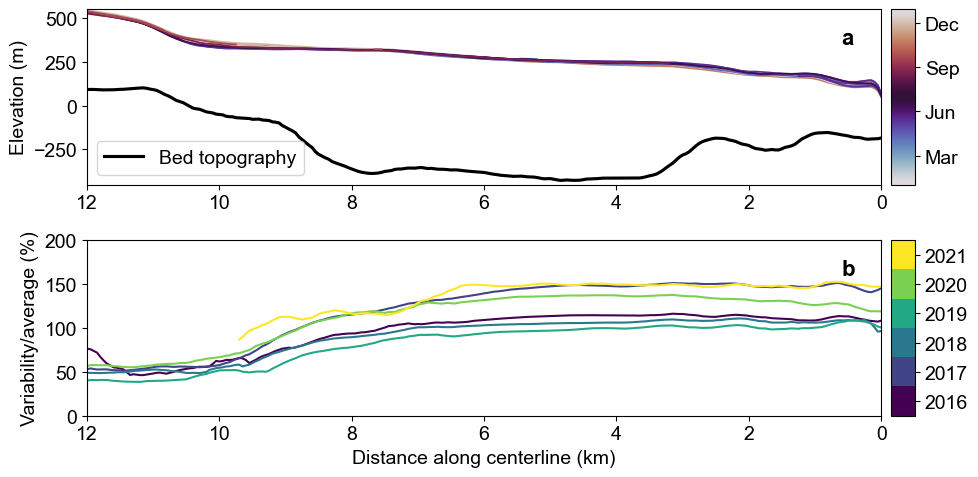

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/elevations_variability_peclet.png


In [175]:
# Set up figure
fontsize=14
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(2, 1, figsize=(10,5))
lw=1.25
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=2):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

def moving_averages(x, w=3):
    return np.convolve(x, np.ones(w), 'same') / w
    
### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    surf = moving_averages(h_cl_df.iloc[i][h_cols])
    ax[0].plot(np.divide(cl_dist, 1e3), surf, '-', linewidth=lw, color=color)
    surf = np.mean(h_cl_df.iloc[i][h_cols])
        
# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
#Pe number
dbdx = np.gradient(bed_cl_smooth, cl_dist)
H_smooth = surf - bed_cl_smooth
Pe = 2 * dbdx/H_smooth * cl_dist
indices = np.where(Pe > 3)[0]
last_index = indices[-1]
x_position = cl_dist[last_index] / 1e3
# Plot the vertical line at the last x_position where Pe > 3
#ax[0].axvline(x=x_position, color='k', linestyle=':', linewidth=1, label='Pe > 3')
#ax[1].axvline(x=x_position, color='k', linestyle=':', linewidth=1)
#print(f"Last position where Pe > 3: {x_position:.2f} km")

ax[0].legend(loc='lower left')
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].set_ylabel('Elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 550)

### b) Speed strengths
cmap = plt.cm.viridis
colors=[]
for i, year in enumerate(years[0:]):
    colors.append(cmap(i/(len(years)-1)))
    percent_avg = np.divide(strengths_cl[year],avgs_cl[year])*100
    line1, = ax[1].plot(np.divide(cl_dist, 1e3), percent_avg, '-', color=colors[i])
#ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl.mean(axis=1), '--k', linewidth=lw+0.5, label='Annual variability (max-min)')
#ax[1].plot(np.divide(cl_dist, 1e3), avgs_cl.mean(axis=1), '-r', linewidth=lw+0.5, label='Annual Average')
#ax[1].plot(np.divide(cl_dist, 1e3), avgs_mean, '-k', linewidth=lw+1, label='Average annual velocity')

# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[:2], labels[:2], loc='upper center')
#ax[1].legend(loc='upper center')
ax[1].set_xlim(xlim)
ax[1].set_ylim([0, 200])
ax[1].set_xlabel('Distance along centerline (km)')
#ax[1].set_ylabel('Velocity (m a$^{-1}$)')
ax[1].set_ylabel('Variability/average (%)')

# Plot colorbar
listed_cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1)  
norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
divider3 = make_axes_locatable(ax[1])
cax3 = divider3.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
cbar.ax.set_yticklabels([f'{year}' for year in years[0:]])  # Customize labels
cbar.ax.tick_params(which='minor', length=0)  

### Add panel labels, adjust axes
labels = ['a', 'b']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+2)
    axis.grid(True)
    # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

plt.sca(ax[0])  # Set the current active axis to ax[0]
plt.grid(False)
plt.sca(ax[1])  # Set the current active axis to ax[0]
plt.grid(False)
fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'elevations_variability_peclet.png')
fig.savefig(fig_fn, dpi=600, bbox_inches='tight')
print('Figure saved to file:', fig_fn)